In [1]:
# import library
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# create ticker object and fetch historical market data
def ticker_history(comp, dt):
    ticker = yf.Ticker(comp)
    df = ticker.history(period=dt)
    return df

In [3]:
# split data into training and test data
def train_test_split(df, tSplit, col):
    train = df.loc[:f'{tSplit}', col].values
    test = df.loc[f'{tSplit+1}':, col].values
    return train, test

In [4]:
# standardize training data
def scale_fit_transform(train, scaler):
    train = train.reshape(-1, 1)
    trainStd = scaler.fit_transform(train)
    return trainStd

In [5]:
# convert training data to inputs and outputs
def split_time_series(seq, step):
    X, y = list(), list()
    for i in range(len(seq)):
        end = i + step
        if end > len(seq) - 1:
            break
        xSeq, ySeq = seq[i:end], seq[end]
        X.append(xSeq)
        y.append(ySeq)
    return np.array(X), np.array(y)

In [6]:
# create LSTM model
def model_lstm(step, feature):
    lstm = Sequential()
    lstm.add(LSTM(units=125, activation='tanh', input_shape=(step, feature)))
    lstm.add(Dense(units=1))
    lstm.compile(optimizer='RMSprop', loss='mse')
    return lstm

In [7]:
# transform test data into samples and inverse transform predictions
def predict_lstm(df, lstm, test, XTest, yTest, col, step):
    dfTot = df.loc[:,col]
    dIn = dfTot[len(dfTot) - len(test) - step :].values
    dIn = dIn.reshape(-1, 1)
    dIn = scaler.transform(dIn)
    XTest, yTest = split_time_series(dIn, step)
    XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], feature)
    yPred = lstm.predict(XTest)
    yPred = scaler.inverse_transform(yPred)
    return XTest, yTest, yPred

In [8]:
comp = ['NVDA', 'AMD']
dt = '5y'
col = 'High'
tSplit = 2023
step = 60
feature = 1
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
# Create dataframe
dfNVDA = ticker_history(comp[0], dt)
dfAMD = ticker_history(comp[1], dt)

trainNVDA, testNVDA = train_test_split(dfNVDA, tSplit, col)
trainAMD, testAMD = train_test_split(dfAMD, tSplit, col)

trainStdNVDA = scale_fit_transform(trainNVDA, scaler)
trainStdAMD = scale_fit_transform(trainAMD, scaler)

XTrainNVDA, yTrainNVDA = split_time_series(trainStdNVDA, step)
XTrainAMD, yTrainAMD = split_time_series(trainStdAMD, step)

# reshape training data to fit on LSTM model
XTrainNVDA = XTrainNVDA.reshape(XTrainNVDA.shape[0], XTrainNVDA.shape[1], feature)
XTrainAMD = XTrainAMD.reshape(XTrainAMD.shape[0], XTrainAMD.shape[1], feature)

In [10]:
lstmNVDA = model_lstm(step, feature)
lstmAMD = model_lstm(step, feature)

# train the model
lstmNVDA.fit(XTrainNVDA, yTrainNVDA, epochs=10, batch_size=32)
lstmAMD.fit(XTrainAMD, yTrainAMD, epochs=10, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0545
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0044
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0019
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0017
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0015
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0011
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0013
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0010
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 8.8101e-04
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0307
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0033
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0032
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0030
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0025
Epo

In [11]:
XTestNVDA, yTestNVDA, yPredNVDA = predict_lstm(dfNVDA, lstmNVDA, testNVDA, XTrainNVDA, yTrainNVDA, col, step)
XTestAMD, yTestAMD, yPredAMD = predict_lstm(dfAMD, lstmAMD, testAMD, XTrainAMD, yTrainAMD, col, step)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [12]:
def plot_train_test(df, tSplit, col, name):
    df.loc[:f'{tSplit}', col].plot(figsize=(14, 4), legend=True)
    df.loc[f'{tSplit+1}':, col].plot(figsize=(14, 4), legend=True)
    plt.legend([f'Train ( - {tSplit+1})', f'Test ({tSplit+1} - )'])
    plt.title(f'{name} Stock price')
    plt.show()

In [15]:
def plot_predict(test, predict, name):
    plt.plot(test, label='Real')
    plt.plot(predict, label='Predict')
    plt.title(f'{name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

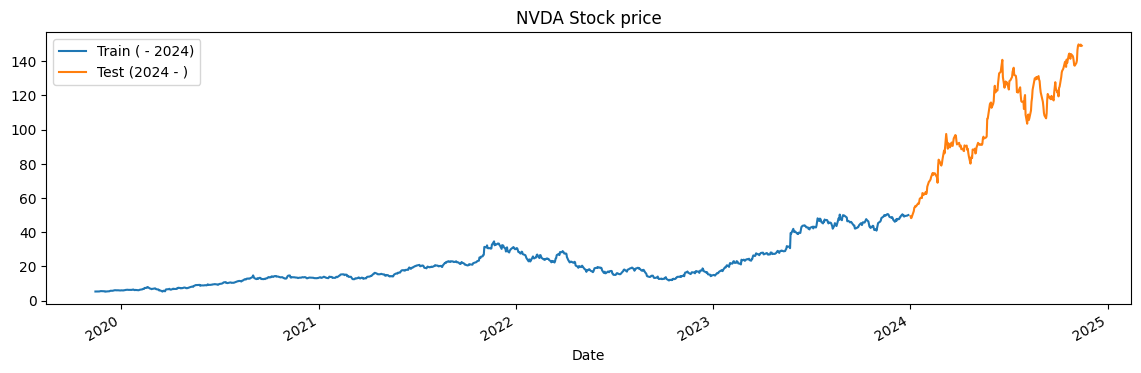

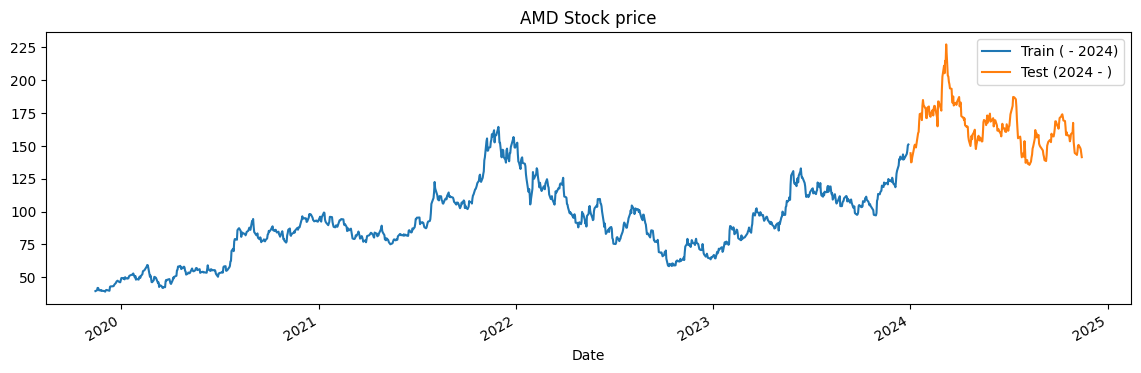

In [14]:
plot_train_test(dfNVDA, tSplit, col, comp[0])
plot_train_test(dfAMD, tSplit, col, comp[1])

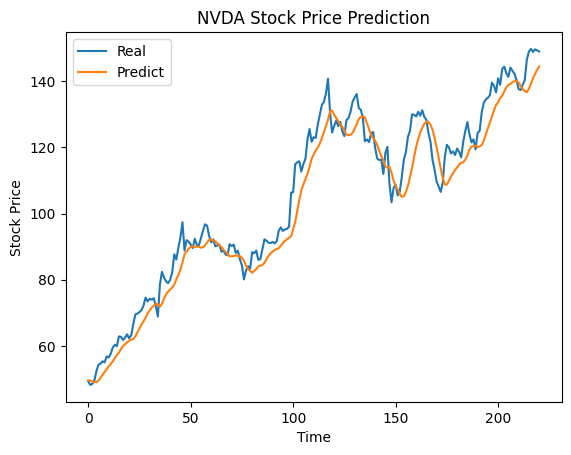

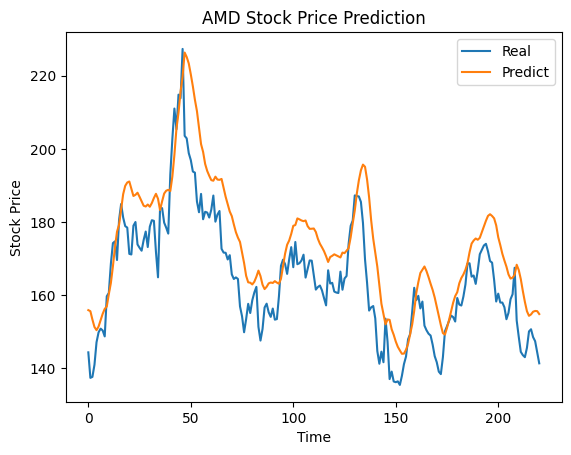

In [16]:
plot_predict(testNVDA, yPredNVDA, comp[0])
plot_predict(testAMD, yPredAMD, comp[1])